### ARDC Burnt Area Validation Workflow ###
This notebook contains several modules to validate the results of burnt area algorithms against data from the ARDC historical burnt area dataset.  
    - Module 1 : Download Burncube rasters from AWS and store locally  
    - Module 2 : Extract vector validation data from the ARDC Historical Fire dataset  
    - Module 3 : Validate the results of the burnt area algorithm  
    - Module 4 : Thematic Analysis of Results
    
### Notebook Setup ###
Import required libraries and tools, as well as define required user inputs.

In [1]:
# Import libraries required for AWS download
import sys
import os
import re
import boto3
import botocore

# Import libraries required for ARDC dataset extraction and validation modules
import rasterio
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import contextily as cx
import datacube
import xarray as xr
import numpy as np
import rioxarray
import getpass
import matplotlib.patheffects as path_effects
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Rectangle

# Import tools and functions from ARDC_burnt_area_mapping_tools.py
from ARDC_burnt_area_mapping_tools import (
    gen_grid_codes,
    download_s3_files,
    ardc_year_calc,
    raster_folder_bbox,
    ValidationStats,
    ReadShapes,
    GetTifs,
    extract_xy,
    calculate_classification_metrics,
    validation_climate_analysis,
)

# Import tools and functions from DEA tools
from dea_tools.spatial import xr_vectorize, xr_rasterize
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.cog import write_cog

# Set AWS environment variable
os.environ["AWS_NO_SIGN_REQUEST"] = "yes"

### User Defined Variables ###
The following variables must be defined by the user to match the burnt area algorithm being validated. This involves setting several variables to the the model output s3 location, as well as defining the AU30 tiles and time period of the study period.

User defined variables are split into three categories for clarity:
1. Burnt Area Algorithm Product Parameters
2. Validation Location and Time Period Parameters
3. Thematic Climate Analysis Parameters

#### Burnt Area Algorithm Product Parameters ####

In [2]:
#Define required user inputs 
#Examples will be given using the following s3 object path
#http://dea-public-data-dev.s3-website-ap-southeast-2.amazonaws.com/?prefix=projects/burn_cube/derivative/ga_ls8c_nbart_bc_cyear_3/
#3-0-0/x14/y21/2020-01-01--P1Y/ga_ls8c_nbart_bc_cyear_3_x14y21_2020-01-01--P1Y_final_wofssevere.tif

#Define the AWS bucket the data is contained within
#E.g. 'dea-public-data-dev'
bucket_name = 'dea-public-data-dev'

#Define the algorithm used to produce the burnt area products
#E.g. 'burncube', 'BAC', 'RF' etc.
algorithm = "burncube"

#Define the name of the parent folders/algorithm run we are extracting results for
# E.g. 'projects/burn_cube/derivative/ga_ls8c_nbart_bc_cyear_3/3-0-0/'
s3_parent_folder = "projects/burn_cube/derivative/ga_ls8c_nbart_bc_cyear_3/3-0-0/"

#Directory date string
#E.g. '2020-01-01'
dir_date = "2020-01-01"

#Define the prefix of each file object up until the unique xy grid code
#E.g. ga_ls8c_nbart_bc_cyear_3_
prefix = 'ga_ls8c_nbart_bc_cyear_3_'

#Define the suffix for the desired files
# E.g. 'wofssevere'
suffix = 'wofssevere'

#Define the files type
#E.g. 'tif'
inputType = 'tif'

#### Validation Location  and Time Period Parameters ####

In [3]:
#Provide a general name of the AOI location, using _ instead of spaces
#E.g. 'East_Vic'
loc_name = "Kangaroo_Island_SA"

#run the gen_grid_code tool to produce a list of x__y__ grid codes for the study AOI
#The input is two tuples, representing (x_min, x_max) and (y_min, y_max)
tile_list = gen_grid_codes((32, 33), (15, 16))
print(loc_name, " grid codes : ", tile_list)

#What is the path to the ARDC dataset?
ardc_fname = r'../Andrew_Validation_Workflows/ARDC_Historical_Data/ARDC_fire_2010.shp'

#What is the path to the coastline dataset?
CoastLineShapeFile = '../Andrew_Validation_Workflows/Data/Coastline_data/ITEMCoastlineCleaned.shp'

#Define the colour scheme to be used in validation figures
colpac = ['#000000', '#e69f00', '#57b4e9', '#019e73', '#f0e442']

#Are we analysing data on a CY of FY basis?
year_basis = "CY"

#What year are we analysing? If using a FY basis, enter the first year over the period (i.e. for 19/20 enter 2019)
year = 2020

#If calculating on a CY year basis, do you want to extend the validation period to capture fires
#that ignited in the early summer months (i.e. 1 for december and 2 for novemeber)?
extra_months = 1

Kangaroo_Island_SA  grid codes :  ['x32y15', 'x32y16', 'x33y15', 'x33y16']


#### Thematic Climate Analysis Parameters ####

In [4]:
#Define a location name and year for your validation AOI. Use '_' instead of spaces.
vali_year = str(year) + " " + year_basis

#Set filepath for the Climate Zone Shapefile and legend
ClimateZoneShapeFile = '../Andrew_Validation_Workflows/Data/Climate_data/Koppen_Climate_Zones.shp'
ClimateLegend_fname = '../Andrew_Validation_Workflows/legend.txt'

### Module 1: Download Burncube rasters from AWS and store locally ###

Download files from a Public AWS s3 bucket and save locally in a folder.

In [5]:
#Create an empty list in which the paths of interest will be stored
path_list = []

#Loop through eacy (x, y) tuple in the tile_list and add the datasets AWS path to the path_list
#Paths are calculated differently depending on the variable specified for algorithm.
for i in tile_list:
    x = re.search(r'x(\d+)', i).group(0)
    y = re.search(r'y(\d+)', i).group(0)
    if algorithm == "burncube":
        path = "{}{}/{}/{}--P1Y/{}{}_{}--P1Y_final_{}.{}".format(s3_parent_folder, x, y, dir_date, prefix, i, dir_date,  suffix,  inputType)
    else: 
        path = "{}{}{}_{}_{}.{}".format(s3_parent_folder, prefix, i, dir_date, suffix, inputType)
    path_list.append(path)
    
path_list

['projects/burn_cube/derivative/ga_ls8c_nbart_bc_cyear_3/3-0-0/x32/y15/2020-01-01--P1Y/ga_ls8c_nbart_bc_cyear_3_x32y15_2020-01-01--P1Y_final_wofssevere.tif',
 'projects/burn_cube/derivative/ga_ls8c_nbart_bc_cyear_3/3-0-0/x32/y16/2020-01-01--P1Y/ga_ls8c_nbart_bc_cyear_3_x32y16_2020-01-01--P1Y_final_wofssevere.tif',
 'projects/burn_cube/derivative/ga_ls8c_nbart_bc_cyear_3/3-0-0/x33/y15/2020-01-01--P1Y/ga_ls8c_nbart_bc_cyear_3_x33y15_2020-01-01--P1Y_final_wofssevere.tif',
 'projects/burn_cube/derivative/ga_ls8c_nbart_bc_cyear_3/3-0-0/x33/y16/2020-01-01--P1Y/ga_ls8c_nbart_bc_cyear_3_x33y16_2020-01-01--P1Y_final_wofssevere.tif']

In [6]:
#Create folder to store files

#Define the folder to save the data into
save_folder = '{}_{}{}_{}_{}'.format(loc_name, prefix, suffix, str(year), year_basis)

# check if the folder already exists. If it does not exist, create it.
if not os.path.exists(save_folder):
    # use the mkdir() method to create the folder
    os.mkdir(save_folder)
else:
    print(f"The folder {save_folder} already exists.")

The folder Kangaroo_Island_SA_ga_ls8c_nbart_bc_cyear_3_wofssevere_2020_CY already exists.


In [7]:
#Download each file into the save_dir directory and Create a list of tifs
TifList = []
for i in path_list:
    save_dir = r'{}/{}'.format(save_folder, i.rsplit('/', 1)[1])
    print(save_dir)
    TifList.append(save_dir)
    
    download_s3_files(bucket_name, i, save_dir)

Kangaroo_Island_SA_ga_ls8c_nbart_bc_cyear_3_wofssevere_2020_CY/ga_ls8c_nbart_bc_cyear_3_x32y15_2020-01-01--P1Y_final_wofssevere.tif
Kangaroo_Island_SA_ga_ls8c_nbart_bc_cyear_3_wofssevere_2020_CY/ga_ls8c_nbart_bc_cyear_3_x32y16_2020-01-01--P1Y_final_wofssevere.tif
Kangaroo_Island_SA_ga_ls8c_nbart_bc_cyear_3_wofssevere_2020_CY/ga_ls8c_nbart_bc_cyear_3_x33y15_2020-01-01--P1Y_final_wofssevere.tif
Kangaroo_Island_SA_ga_ls8c_nbart_bc_cyear_3_wofssevere_2020_CY/ga_ls8c_nbart_bc_cyear_3_x33y16_2020-01-01--P1Y_final_wofssevere.tif


In [8]:
#OPTIONAL: for validating results not stored in s3
#Store the geotiff files in the folder created above, without running the cells to download from s3.
#Then manually enter the paths of each raster into the TifList variable below
#Then run from Module 2
#TifList = ['folder/raster.tif']

### Module 2: Extract vector validation data from the ARDC Historical Fire dataset ###
This module calculates the geographical extent of the geotifs downloaded in module 1, and uses this to filter the ARDC dataset for overlapping validation data.

Additionally, the ARDC dataset is filtered for the year being analysed.

The ARDC dataset can be downloaded [here](https://ecat.ga.gov.au/geonetwork/srv/api/records/a82c263f-dba6-457a-aafd-bf869fe7171a)

In [9]:
# Open each tif file in the sae_folder directory and calculate bounding extent using the raster_folder_bbox tool
polygon, poly_crs = raster_folder_bbox(save_folder)

In [10]:
#Calculate the time period validation data will be extracted for, considering the analysis year, year basis, and optional additional months for CY analysis.
time_period = ardc_year_calc(year_basis, year, extra_months)

Start Date: 2019-12-01
End Date: 2020-12-31


In [11]:
#Load the ARDC shapefile into a gdf
ardc_gdf = gpd.read_file(ardc_fname)

#Create a gdf using the polygon object created from the extent of BC geotifs
#Set its crs and transform to the ardc_gdf crs
poly_gdf = gpd.GeoDataFrame(geometry=[polygon])
poly_gdf = poly_gdf.set_crs(poly_crs)
poly_gdf = poly_gdf.to_crs(ardc_gdf.crs)

#Change crs of both gdf to 3577
ardc_gdf = ardc_gdf.to_crs(3577)
poly_gdf = poly_gdf.to_crs(3577)

In [12]:
#Filter the ardc_gdf using the spatial and time period parameters calculated in previous cells

#Filter the gdf using the polygon object calculated from the extent of the downloaded BC geotiffs
ardc_gdf_fil = gpd.overlay(poly_gdf, ardc_gdf, how='intersection', keep_geom_type=False)

#Filter the gdf using the time period calculated above
ardc_gdf_fil = ardc_gdf_fil[(ardc_gdf_fil['ignition_d'] >= time_period[0]) & (ardc_gdf_fil['ignition_d'] <= time_period[1])]

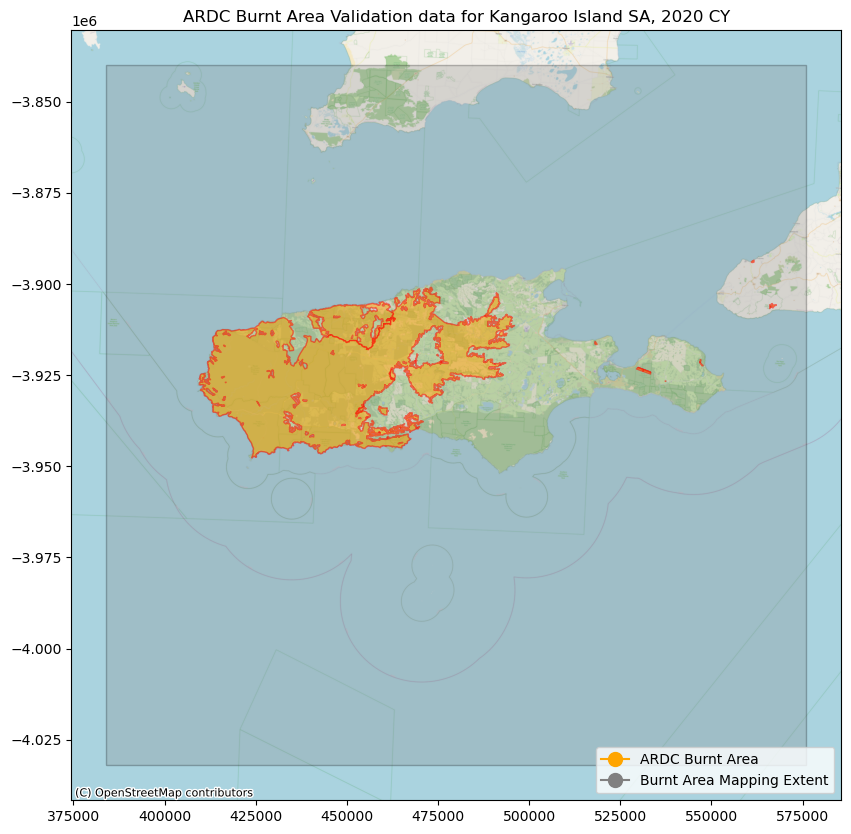

In [13]:
#Create a plot showing all the extracted ardc data over a basemap
#Plot BC tile polygon
ax = poly_gdf.plot(alpha = 0.25, figsize=(10, 10), color = "grey", edgecolor="black")

#PLot the Burnt Areas
ardc_gdf_fil.plot(ax=ax, alpha=0.5, color="orange", edgecolor='red')

#Set title, replacing underscores with spaces in the loc_name
ax.set_title("ARDC Burnt Area Validation data for {}, {}".format(loc_name.replace("_", " "), vali_year))

#Plot basemap from OSM
cx.add_basemap(ax, crs=ardc_gdf_fil.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=12)


# Create the legend handles and labels
handles = [mlines.Line2D([], [], color="orange", marker="o", markersize=10, label="ARDC Burnt Area"),
           mlines.Line2D([], [], color="grey", marker="o", markersize=10, label="Burnt Area Mapping Extent")]

# Add the legend to the plot
ax.legend(handles=handles, loc='lower right')

# Save the plot to a PNG file
plt.savefig("{}/{}_{}_{}_ardc_burnt_area_polygons.png".format(save_folder, loc_name, vali_year.replace(" ", "_"), algorithm))

In [14]:
# Export the filtered ardc gdf to shapefile
shapefile_outpath = save_folder + "/{}_{}_{}_ARDC_polygons".format(
    loc_name, year, year_basis
)
ardc_gdf_fil.to_file(shapefile_outpath)
print("Filtered ARDC data exported to {}".format(shapefile_outpath))

Filtered ARDC data exported to Kangaroo_Island_SA_ga_ls8c_nbart_bc_cyear_3_wofssevere_2020_CY/Kangaroo_Island_SA_2020_CY_ARDC_polygons


### Module 3 : Validate the results of the burnt area algorithm ###


In [15]:
#Calculate the title of the validation plot
FigTitle = 'Validated Burnt Area Mapping Results for {}, {} : {} {} burn'.format(loc_name.replace("_", " "), vali_year, algorithm, suffix)

# Define ground truth shapefile. If different from polygons extracted in Module 2, manually set filepath.
#GroundTruthFile = 'manual filename'
GroundTruthFile = shapefile_outpath + "/{}_{}_{}_ARDC_polygons.shp".format(
    loc_name, year, year_basis
)

In [16]:
# Get shape files for Ground Truth and CoastLine using the ReadShapes function
GTF, CLSF, StateBndry = ReadShapes(GroundTruthFile, CoastLineShapeFile)

In [17]:
#Check to see if the TifList variable is populated.
#If it is not populated, recalculate using the GetTifs function to create a list of all tif files in the save folder
if TifList == []:
    TifList = GetTifs(save_folder, suffix)

# Run through TifList to give a list of x, y coordinates to output to metadata
TifC = []
for i in TifList:
    xx, yy = extract_xy(i)
    TifC.append([xx,yy])
TifCoords = str(TifC)[1:-1]

#Return the TifList
TifList

['Kangaroo_Island_SA_ga_ls8c_nbart_bc_cyear_3_wofssevere_2020_CY/ga_ls8c_nbart_bc_cyear_3_x32y15_2020-01-01--P1Y_final_wofssevere.tif',
 'Kangaroo_Island_SA_ga_ls8c_nbart_bc_cyear_3_wofssevere_2020_CY/ga_ls8c_nbart_bc_cyear_3_x32y16_2020-01-01--P1Y_final_wofssevere.tif',
 'Kangaroo_Island_SA_ga_ls8c_nbart_bc_cyear_3_wofssevere_2020_CY/ga_ls8c_nbart_bc_cyear_3_x33y15_2020-01-01--P1Y_final_wofssevere.tif',
 'Kangaroo_Island_SA_ga_ls8c_nbart_bc_cyear_3_wofssevere_2020_CY/ga_ls8c_nbart_bc_cyear_3_x33y16_2020-01-01--P1Y_final_wofssevere.tif']

In [18]:
# Create single xarray out of combined True/False/Positive/Negative tiles
CombineList = []
TPTotal, FNTotal, FPTotal, TNTotal = 0, 0, 0, 0
for i, item in enumerate(TifList):
    Comby, TP, FN, FP, TN = ValidationStats(item, GTF, CLSF, StateBndry, inputType, colpac, GraphOut=False)
    Comby.name = 'var'
    CombineList.append(Comby)
    TPTotal += TP
    FNTotal += FN
    FPTotal += FP
    TNTotal += TN
    


In [19]:
#Merge the validated tifs into a single array
#First try xarray merge. If a merge error is raised, try combinging by coords.
try:
    CombineArray = xr.merge(CombineList).to_array()
    print("CombineArray created by xarray merge")
except xr.MergeError:
    CombineArray = xr.combine_by_coords(CombineList).to_array()
    print("CombineArray created by xarray combine_by_coords")

CombineArray created by xarray merge


In [20]:
#Create a metric list of desired ML classification performance metrics. See function file for available metrics.
metric_list = ["precision", "recall", "f1-score"]

#Calcualte the desired metrics using the calculate_classification_metrics function.
accuracy_metrics = calculate_classification_metrics(TP = TPTotal, TN = TNTotal, FP = FPTotal, FN = FNTotal, metrics = metric_list)
accuracy_metrics

{'precision': 0.979672495417908,
 'recall': 0.7377009651656679,
 'f1-score': 0.8416402861733622}

In [21]:
# Calculate Precision and Recall totals and determine title string for the figure

# Precision = TP/(TP+FP)
if TPTotal+FPTotal > 0 and TPTotal > 0:
    Prec =  round(100*accuracy_metrics["precision"], 1)
    PrecStr = 'Precision = ' + str(Prec) + '%'
else:
    PrecStr = 'Precision is undefined'

# Recall = TP/(FN+TP)
if FNTotal+TPTotal > 0 and TPTotal > 0:
    Rec = round(100*accuracy_metrics["recall"], 1)
    RecStr = 'Recall = ' + str(Rec) + '%'
else:
    RecStr = 'Recall is undefined'
    
# Total pixels
Total = TPTotal+FPTotal+TNTotal+FNTotal

PrintString = 'True Positive: ' + str("{:.2g}".format(100*TPTotal/Total)) + '%\nTrue Negative: ' + str("{:.2g}".format(100*TNTotal/Total)) + \
                  '%\nFalse Positive: ' + str("{:.2g}".format(100*FPTotal/Total)) + '%\nFalse Negative: ' + str("{:.2g}".format(100*FNTotal/Total)) + '%' + \
                  PrecStr + RecStr

TPStr = 'True Positive: ' + str("{:.2g}".format(100*TPTotal/Total)) + '%'
FNStr = 'False Negative: ' + str("{:.2g}".format(100*FNTotal/Total)) + '%'
FPStr = 'False Positive: ' + str("{:.2g}".format(100*FPTotal/Total)) + '%'
TNStr = 'True Negative: ' + str("{:.2g}".format(100*TNTotal/Total)) + '%'

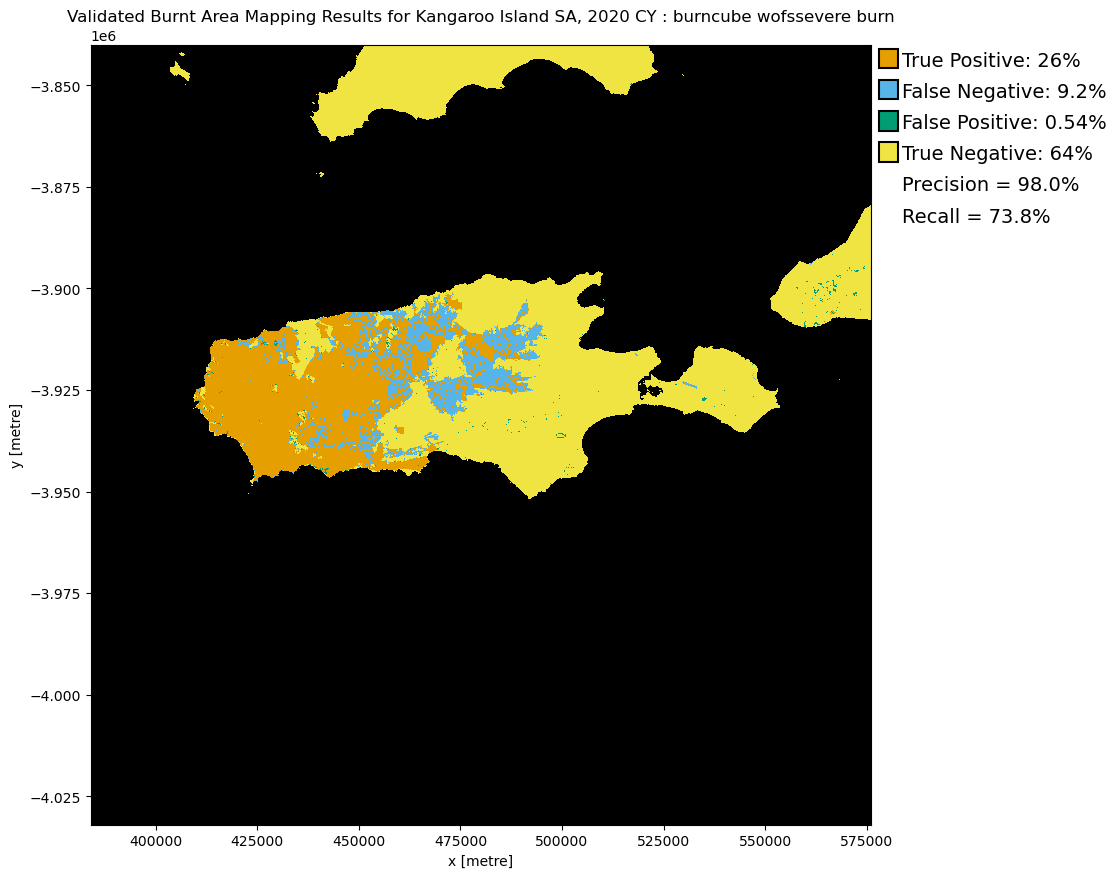

In [22]:
# Select only those colours that are represented in the data

# select unique values
uniqVals = np.unique(CombineArray)

# Remove nan from unique values and convert remaining floats to ints
colnums = uniqVals[~np.isnan(uniqVals)].astype(int)

# Select only colours that correspond to data values in array
colpac2= [colpac[i] for i in colnums]

#
# Make final plot
#
fig, axes = plt.subplots(1, 1, figsize=(12,12))
plt.subplots_adjust(left=0.1, right=0.75, top=0.9, bottom=0.1)

CombineArray[0].plot(ax=axes, levels=[0.5,1.5,2.5,3.5,4.5], colors=colpac2, add_colorbar=False)

strDic = {0: TPStr, 1: FNStr, 2: FPStr, 3: TNStr, 4: PrecStr, 5: RecStr}
#colDic = {0: colpac2[0], 1: colpac2[3], 2: colpac2[2], 3: colpac2[1]}

for i in range(6):
    axes.text(1.04, 0.98-(0.04*i), strDic[i], ha='left', va='center', size=14, color='k', transform = axes.transAxes)
    if i<4:
        rect = Rectangle((1.01, 0.97-(0.04*i)), 0.025, 0.025, linewidth=1.5, edgecolor='black', facecolor=colpac[i+1], clip_on=False, transform = axes.transAxes)
        axes.add_patch(rect)

axes.set_aspect('equal', adjustable='box')

axes.set_title(FigTitle)

#Define the filename of the output png image and export to png
png_filepath = '{}/{}_{}{}.png'.format(save_folder, loc_name, prefix, suffix)
plt.savefig(png_filepath, dpi=300)

In [23]:
# Save combined array as tiff
tif_filepath = '{}/{}_{}{}.tif'.format(save_folder, loc_name, prefix, suffix)

write_cog(geo_im=CombineArray,
          fname=tif_filepath,
          overwrite=True)

#
# Write out metadata
#
metadata = {
    'date': datetime.now(),
    'user': getpass.getuser(),
    'Location' : loc_name.replace("_", " "),
    'Algorithm' : algorithm,
    'Algorithm Run': prefix,
    'AU30 Tiles' : TifCoords,
    'Validation Data' : GroundTruthFile,
    'Validation CRS' : gpd.read_file(GroundTruthFile).crs,
    'Validation ARDC time period' : time_period,
    'Validation ARDC spatial extent' : polygon,
    'Validation Raster' : prefix+suffix+'.tif',
    'Coastline Data' : CoastLineShapeFile,
    'Precision' : Prec,
    'Recall' : Rec,
    'Total Pixels': Total,
    'True Positive Pixels': TPTotal,
    'False Positive Pixels': FPTotal,
    'True Negative Pixels': TNTotal,
    'False Negative Pixels': FNTotal

}

with open('{}/metadata_{}_{}_{}.txt'.format(save_folder, loc_name, prefix, suffix), 'w') as f:
    for key, value in metadata.items():
        f.write(f"{key}: {value}\n")

### Module 4 : Thematic Analysis of Results ###

This module analyses the Precision and recall values calculated during the main Validation workflow by KÖPPEN-GEIGER Climate Classification.

Other similar thematic polygon data could be used to segment the previous results.

The input for this module is a validated raster with the following classification scheme : {0 : nodata, 1 : TP, 2 : FP, 3 : FN, 4 : TN } 

The KÖPPEN-GEIGER classes used where vectorised from a 1km resolution raster produced by [Beck et al. [2018]](https://www.nature.com/articles/sdata2018214) that can be accessed [here](https://www.gloh2o.org/koppen/)

    Beck, H.E., N.E. Zimmermann, T.R. McVicar, N. Vergopolan, A. Berg, E.F. Wood:
    Present and future Köppen-Geiger climate classification maps at 1-km resolution,
    Nature Scientific Data, 2018.

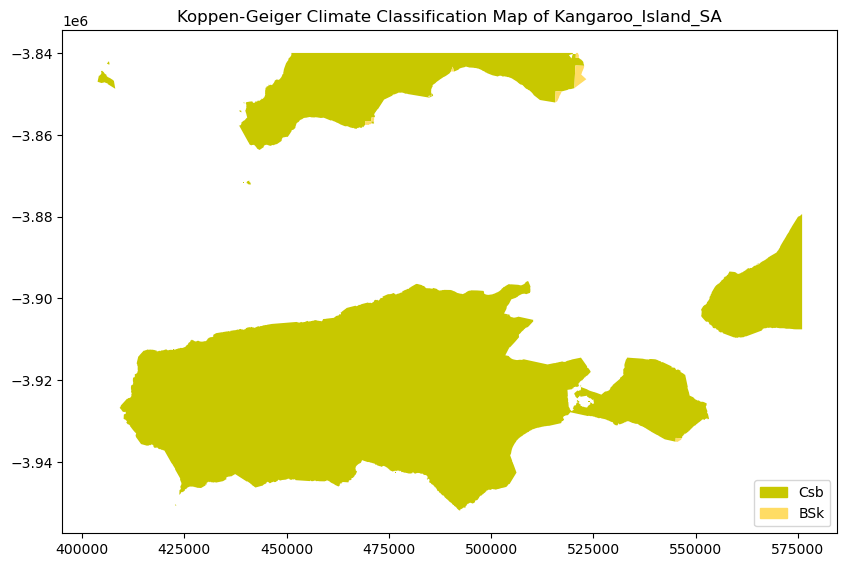


Precision is undefined for Climate Class BSk

Recall is undefined for Climate Class BSk

Precision is 98.01% for Climate Class Csb

Recall is 73.76% for Climate Class Csb


In [24]:
#Call the validation_climate_analysis function to calculate precision and recall by climate zone
#If not using the combined array from the previous module, manually set the first argument

climate_df = validation_climate_analysis(tif_filepath, ClimateZoneShapeFile, ClimateLegend_fname, loc_name, vali_year)

In [25]:
# Define a style function for the visualisation of the results
def result_visuals(styler):
    styler.set_caption(
        "Climate Class Validation Results for {}, {}".format(loc_name.replace("_", " "), vali_year)
    )
    styler.format(
        {
            "Precision": lambda x: f"{x*100:.1f}%",
            "Recall": lambda x: f"{x*100:.1f}%",
            "Area_Percent": lambda x: f"{x*100:.1f}%",
        }
    )
    styler.background_gradient(
        subset=["Precision", "Recall"], vmin=0.3, vmax=1, cmap="RdYlGn"
    )
    return styler


# Visualise the results in table format
climate_df.style.pipe(result_visuals)

,Name,Description,Area_Percent,Precision,Recall
1,Csb,"Temperate, dry summer, warm summer",100.0%,98.0%,73.8%


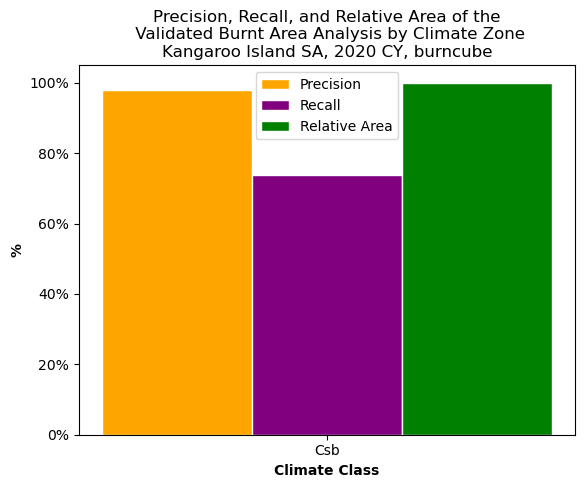

In [26]:
# Get the climate classes and their corresponding precision and recall values
classes = climate_df.Name
precisions = climate_df["Precision"].values
recalls = climate_df["Recall"].values
areas = climate_df["Area_Percent"].values

# Set the width of the bars
barWidth = 0.25

# Set the position of the bars on the x-axis
r1 = np.arange(len(classes))
r2 = [x + barWidth for x in r1]
r3 = [x + 2 * barWidth for x in r1]

# Create the bar plot
plt.bar(
    r1, precisions, color="orange", width=barWidth, edgecolor="white", label="Precision"
)
plt.bar(r2, recalls, color="purple", width=barWidth, edgecolor="white", label="Recall")
plt.bar(
    r3, areas, color="green", width=barWidth, edgecolor="white", label="Relative Area"
)

# Set the y-axis to show percentages (0-100%)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

# Add xticks on the middle of the group bars
plt.xlabel("Climate Class", fontweight="bold")
plt.ylabel("%", fontweight="bold")
plt.xticks([r + barWidth for r in range(len(classes))], classes)

# Add legend
plt.legend()

# Add title
plt.title(
    "Precision, Recall, and Relative Area of the\n Validated Burnt Area Analysis by Climate Zone\n{}, {}, {}".format(
        loc_name.replace("_", " "), vali_year, algorithm
    )
)

# Save the plot as a PNG image. First calculate the folder and raster name frmo the fname variable.
save_folder = tif_filepath.split("/")[0]
save_name = tif_filepath.rsplit('/', 1)[-1].rsplit('.', 1)[0]
plt.savefig("{}/{}_{}_{}_climate_analysis_graph.png".format(save_folder, loc_name, vali_year.replace(" ", "_"), algorithm))

#Display the plot
plt.show()  

In [27]:
# Export the results from results_df to csv
# Define csv fname
csv_fname = "{}/{}_{}_Climate_Validation_statistics.csv".format(save_folder, loc_name, vali_year)
# Export df
climate_df.to_csv(csv_fname, index=False)

##### Print library versions #####

In [28]:
print("Python:", sys.version)
print("Boto3:", boto3.__version__)
print("Botocore:", botocore.__version__)
print("Rasterio:", rasterio.__version__)
print("Geopandas:", gpd.__version__)
print("Contextily:", cx.__version__)
print("Datacube:", datacube.__version__)
print("Xarray:", xr.__version__)
print("Numpy:", np.__version__)
print("Rioxarray:", rioxarray.__version__)

Python: 3.8.10 | packaged by conda-forge | (default, Sep 13 2021, 21:46:58) 
[GCC 9.4.0]
Boto3: 1.26.76
Botocore: 1.29.76
Rasterio: 1.3.4
Geopandas: 0.13.0
Contextily: 1.3.0
Datacube: 1.8.13
Xarray: 2023.1.0
Numpy: 1.24.3
Rioxarray: 0.13.4
